In [1]:
import torch
from torch.nn import functional as F
from torch import nn
import torchvision
import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch.optim as optim
import torch.nn.init as init

In [2]:
trainset = FashionMNIST("./temp/", train=True, download=True)
testset = FashionMNIST("./temp/", train=False, download=True)

In [3]:
train_x = trainset.data[:53000].float()/255
train_y = trainset.targets[:53000]

validation_x = trainset.data[53000:60000].float()/255
validation_y = trainset.targets[53000:60000]

test_x = testset.data/255
test_y = testset.targets

In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.lin1 = nn.Linear(in_features=64*7*7, out_features=128)
        self.lin2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [5]:
train_x = train_x.unsqueeze(1)
validation_x = validation_x.unsqueeze(1)
test_x = test_x.unsqueeze(1)

In [6]:
train_x.shape

torch.Size([53000, 1, 28, 28])

In [7]:
torch.cuda.is_available()

True

In [8]:
train_x = train_x.cuda()
train_y = train_y.cuda()

validation_x = validation_x.cuda()
validation_y = validation_y.cuda()

test_x = test_x.cuda()

In [9]:
model = CNNModel().cuda()

In [14]:
batch_size = 256
num_epochs = 30
num_batches_per_train_epoch = train_x.shape[0] // batch_size
num_batches_validation = validation_x.shape[0] // batch_size

In [15]:
optimizer = optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [16]:
def get_accuracy(predictions, targets):
  length = len(predictions)
  correct = 0
  for idx in range(length):
    if predictions[idx] == targets[idx]: correct +=1

  return (correct/length) * 100

In [17]:
epoch_loss = 0
losses_at_each_epoch = list()
train_accuracies = list()
validation_accuracies = list()

for epoch in range(num_epochs):
  epoch_loss = 0

  model.train()
  train_preds = list()
  train_targets = list()

  for batch_idx in range(num_batches_per_train_epoch):

    optimizer.zero_grad()

    input = train_x[batch_idx*batch_size: (batch_idx+1)*batch_size]
    output = model(input)
    target_out = train_y[batch_idx*batch_size: (batch_idx+1)*batch_size]
    preds = torch.argmax(output, dim=1)

    train_preds +=(list(preds.detach().cpu().numpy()))
    train_targets+=(list(target_out.detach().cpu().numpy()))
    batch_loss = criterion(output, target_out)

    batch_loss.backward()
    optimizer.step()
    epoch_loss += batch_loss
  losses_at_each_epoch.append(epoch_loss.detach().cpu() / batch_size)

  model.eval()

  val_preds = list()
  val_targets = list()

  for batch_idx in range(num_batches_validation):
    input = validation_x[batch_idx*batch_size: (batch_idx+1)*batch_size]
    output = model(input)
    target_out = validation_y[batch_idx*batch_size: (batch_idx+1)*batch_size]
    preds = torch.max(output, 1)[1]


    val_preds += (list(preds.detach().cpu().numpy()))
    val_targets+=(list(target_out.detach().cpu().numpy()))

  train_accuracies.append(get_accuracy(train_preds, train_targets))
  validation_accuracies.append(get_accuracy(val_preds, val_targets))

  print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
              epoch, losses_at_each_epoch[-1], train_accuracies[-1], validation_accuracies[-1]))


Epoch  0 : Train Loss 1.764383 , Train acc 29.727129, Valid acc 52.835648
Epoch  1 : Train Loss 0.926152 , Train acc 64.260643, Valid acc 70.326968
Epoch  2 : Train Loss 0.608028 , Train acc 72.792120, Valid acc 72.135417
Epoch  3 : Train Loss 0.553524 , Train acc 74.701842, Valid acc 73.683449
Epoch  4 : Train Loss 0.520261 , Train acc 76.253019, Valid acc 74.956597
Epoch  5 : Train Loss 0.495811 , Train acc 77.353185, Valid acc 75.564236
Epoch  6 : Train Loss 0.476375 , Train acc 78.300498, Valid acc 76.591435
Epoch  7 : Train Loss 0.459799 , Train acc 79.028910, Valid acc 78.211806
Epoch  8 : Train Loss 0.445211 , Train acc 79.749774, Valid acc 78.978588
Epoch  9 : Train Loss 0.432727 , Train acc 80.400815, Valid acc 79.890046
Epoch 10 : Train Loss 0.421004 , Train acc 81.023551, Valid acc 80.237269
Epoch 11 : Train Loss 0.410247 , Train acc 81.574577, Valid acc 81.134259
Epoch 12 : Train Loss 0.400435 , Train acc 82.116168, Valid acc 81.857639
Epoch 13 : Train Loss 0.391230 , Train

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

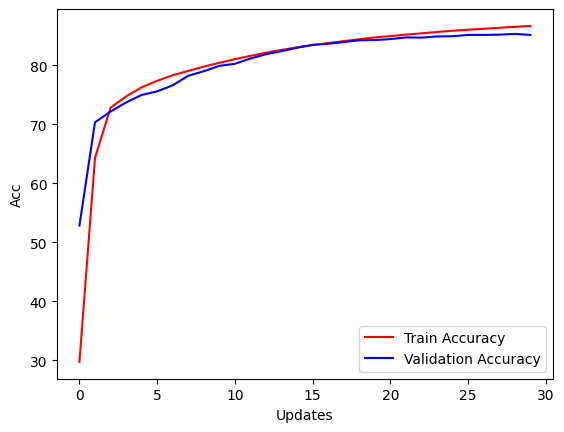

In [18]:
epoch = np.arange(len(train_accuracies))
plt.figure()
plt.plot(epoch, train_accuracies, 'r', epoch, validation_accuracies, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

In [19]:
get_accuracy(torch.argmax(model(test_x),dim=1).detach().cpu().numpy(), test_y)

84.7

In [20]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
num_params

421642